In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import math
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import chi2
from pylab import barh,plot,yticks,show,grid,xlabel,figure
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the data in
heartDisease = pd.read_pickle("heartDisease.pkl")

In [25]:
X_headers = pd.DataFrame(X, columns=['Age','Sex','Chest Pain', 'Resting BP', 'Cholesterol',
                                   'Fasting Blood Sugar', 'ECG Results', 'Max HR', 'Angina', 'Old Peak',
                                   'ST Slope', 'Dx Vessels', 'Thal', 'Presence of Heart Disease'])

In [5]:
X = np.array(X)

print(X.shape)

(270, 14)


In [11]:
print(X[:,:-1].shape, X[:,-1].shape)

(270, 13) (270,)


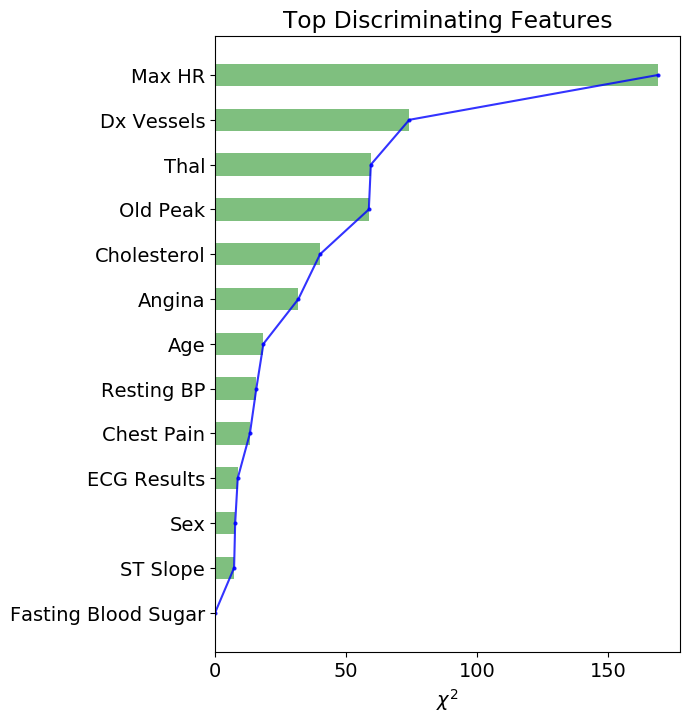

In [48]:
chi2score = chi2(X[:,:-1], X[:,-1])[0]
wscores = zip(list(X_headers.columns.values), chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = zip(*wchi2[-50:])
topchi2list = list(topchi2)

plt.rcdefaults()
plt.rcParams.update({'font.size': 14}) 
plt.figure(figsize=(6,8))
x = np.arange(len(topchi2list[1]))
barh(x, topchi2list[1], align='center',height=0.5, alpha=0.5, color='g')
plot(topchi2list[1], x, '-o', markersize=2, alpha=.8, color='b')
labels = topchi2list[0]
yticks(x,labels)
plt.title('Top Discriminating Features')
xlabel('$\chi^2$')
show()
#plt.savefig('discriminating_features.png')

In [36]:
# set number of iterations for bootstrapping
n_iterations = 1000
# set size of 
n_size = int(len(X))
# empty lists
results = []
cont = []
# size of trees in sample to iterate through
trees = [11, 51, 101, 201, 301, 401, 501]

for t in range(len(trees)):    
    truth = []
    rf_bs_prediction = []
    print("Model ", t, ": Random Forest trees = " + str(trees[t]))
    #set up model
    rf_bs = RandomForestClassifier(n_estimators=trees[t], criterion='entropy', n_jobs=-1)
    #begin bootstrapping
    for i in range(n_iterations):
        trainX = resample(X, n_samples=n_size, replace=True)
        #print(trainX.shape)
        trainy = np.array([x for x in X if x.tolist() not in trainX.tolist()])
        #print(trainy.shape)
        truth.append(trainy[:,-1])
        rf_bs.fit(trainX[:,:-1], trainX[:,-1])
        Y_hat = rf_bs.predict(trainy[:,:-1])
        rf_bs_prediction.append(Y_hat)
    truth = np.concatenate(truth, axis=0)
    rf_bs_prediction = np.concatenate(rf_bs_prediction, axis=0)
    test_results = np.sum(rf_bs_prediction == truth) / len(truth)
    print("    Overall test accuracy: %.2f %%" % (test_results * 100))
    rf_bs = rf_bs.fit(X[:,:-1], X[:,-1])
    Y_hat = rf_bs.predict(X[:,:-1])
    train_results = np.sum(Y_hat == X[:,-1]) / len(X[:,-1])
    print("    Overall training accuracy: %.2f %%" % (train_results * 100))
    results.append([train_results, test_results])   
    cont.append([truth, rf_bs_prediction])    

    

Model  0 : Random Forest trees = 11
    Overall test accuracy: 79.85 %
    Overall training accuracy: 99.26 %
Model  1 : Random Forest trees = 51
    Overall test accuracy: 81.51 %
    Overall training accuracy: 100.00 %
Model  2 : Random Forest trees = 101
    Overall test accuracy: 81.83 %
    Overall training accuracy: 100.00 %
Model  3 : Random Forest trees = 201
    Overall test accuracy: 82.11 %
    Overall training accuracy: 100.00 %
Model  4 : Random Forest trees = 301
    Overall test accuracy: 81.94 %
    Overall training accuracy: 100.00 %
Model  5 : Random Forest trees = 401
    Overall test accuracy: 81.98 %
    Overall training accuracy: 100.00 %
Model  6 : Random Forest trees = 501
    Overall test accuracy: 82.03 %
    Overall training accuracy: 100.00 %


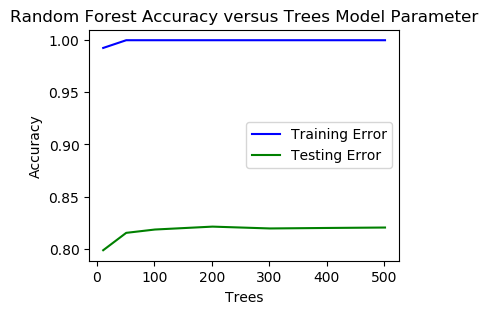

In [37]:
tracc = [item[0] for item in results]
tstacc = [item[1] for item in results]

plt.rcdefaults()
plt.figure(figsize=(4,3))
trainAcc = plt.plot(trees, tracc, '-b', label='Training Error')
testACC = plt.plot(trees, tstacc, '-g', label='Testing Error')
plt.title("Random Forest Accuracy versus Trees Model Parameter")
plt.ylabel("Accuracy")
plt.xlabel("Trees")
plt.legend(loc="best")
plt.show(block=False)

In [42]:
model = input("Enter Best Model: ")
best = cont[int(model)]
rf_ct = pd.crosstab(best[1], best[0], margins=True)
rf_ct.columns = ["-'ve HD", "+'ve HD", "Total"]
rf_ct.index = ["-'ve HD", "+'ve HD", "Total"]
print()
print("Random Forest")
print(rf_ct)
print()

Enter Best Model: 3

Random Forest
         -'ve HD  +'ve HD  Total
-'ve HD    47629    10359  57988
+'ve HD     7392    33857  41249
Total      55021    44216  99237



In [43]:
Sens = rf_ct.iloc[1][1]/rf_ct.iloc[2][1]
Spec = rf_ct.iloc[0][0]/rf_ct.iloc[2][0]
PPV = rf_ct.iloc[1][1]/rf_ct.iloc[1][2]
NPV = rf_ct.iloc[0][0]/rf_ct.iloc[0][2]
ACC = (rf_ct.iloc[0][0] + rf_ct.iloc[1][1]) / rf_ct.iloc[2][2]
print("Random Forest: Sensitivity: %.2f Specificity: %.2f PPV: %.2f NPV: %.2f Accuracy: %.2f" % (Sens, Spec, PPV, NPV, ACC))                                                                                      

Random Forest: Sensitivity: 0.77 Specificity: 0.87 PPV: 0.82 NPV: 0.82 Accuracy: 0.82


Feature ranking:
1. feature 12 (0.125197)
2. feature 7 (0.111627)
3. feature 2 (0.111428)
4. feature 11 (0.111275)
5. feature 9 (0.110318)
6. feature 4 (0.096234)
7. feature 0 (0.089157)
8. feature 3 (0.086485)
9. feature 10 (0.045329)
10. feature 8 (0.042088)
11. feature 1 (0.034207)
12. feature 6 (0.026371)
13. feature 5 (0.010285)


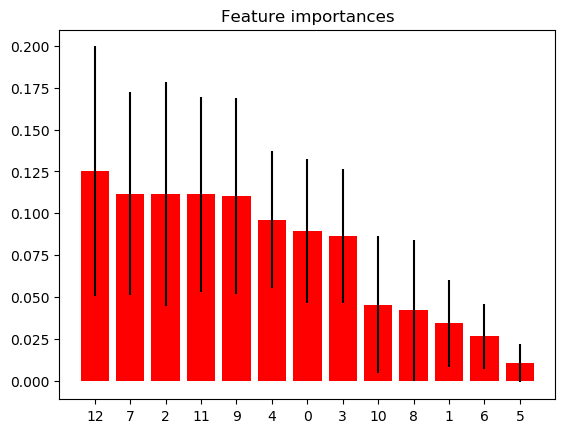

In [44]:
x_features = X[:,:-1]

# look at most discriminant features in model
importances = rf_bs.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_bs.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_features.shape[1]), indices)
plt.xlim([-1, x_features.shape[1]])
plt.show()

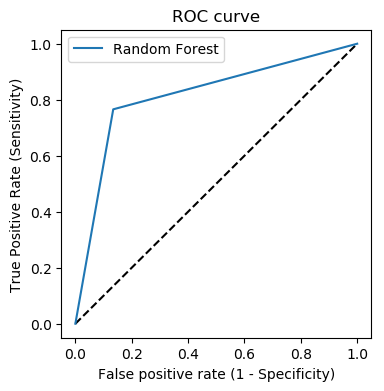

AUC =  0.815684794399291


In [45]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(best[0], best[1], pos_label=2)
roc_auc = auc(rf_fpr, rf_tpr)
plt.rcdefaults()
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot( rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)